In [6]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns

#Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.utils import class_weight

#Tensorflow
import tensorflow as tf
import tensorflow.keras.layers as lyrs
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam

root="/kaggle/input/poultry-diseases-detection/poultry_diseases"
IMG_SIZE=224

In [7]:
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))
    
def view_random_image(root_path,folder,class_folder):
    path=root_path+'/'+folder+'/'+class_folder
    rand=random.choice(os.listdir(path))
    random_image=mpimg.imread(path+'/'+rand)
    plt.imshow(random_image)
    plt.title("File Name: " + rand)
    
def pre_process_image(path, image_shape=224, channels=3, norm_factor=255.):
    '''Pre-Processing the Image before sending it to the model'''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=channels)
    img = tf.image.resize(img, size = (image_shape, image_shape))
    img = tf.expand_dims(img, axis=0)
    img = img/norm_factor
    return img

def random_tester(root_path, classes, model, class_type="binary"):
    '''Random Class Folder Selection'''
    path=root_path
    class_folder=random.choice(os.listdir(path))
    
    '''Random File Selection'''
    folder_path=path+'/'+class_folder+'/'
    rand=random.choice(os.listdir(folder_path))
    file_path=folder_path+'/'+rand
    random_image=mpimg.imread(file_path)
    
    '''Prediction'''
    predicted_value=model.predict(pre_process_image(file_path)) 
    if(class_type=="binary"):
        predicted_label=classes[custom_rounder(predicted_value)]
    else:
        index=tf.math.round(predicted_value).numpy()
        index=np.argmax(index)
        predicted_label=classes[index]
        
    '''Visualize'''
    plt.imshow(random_image)
    plt.title("Prediction:" + predicted_label +"\n" +"True class: "+ class_folder)
    plt.show()
    
def loss_curve_plot(df):
    """ Dataframe (df) is history of the fit of the NN model
    The df consists of train and validation fit data
    """
    history = df.history
    val_accuracy = history["val_accuracy"]
    val_loss = history["val_loss"]
    train_accuracy = history["accuracy"]
    train_loss = history["loss"]
    
    """Accuracy Plot"""
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
    """Loss Plot"""
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Loss Curves")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
def confusion_matrix_plot(y_true, y_pred, figsize=(30,30)):
    """"Confusion Matrix for true values and predicted values"""
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)
    plt.figure(figsize = figsize)
    sns.heatmap(cm, annot=True, cmap="crest")

In [8]:
augmentation=ImageDataGenerator(
    rescale=1/225.,
    validation_split=0.2,
    vertical_flip=True,
    rotation_range=0.45,
    brightness_range=[0.2,1]
)

train_datagen=augmentation.flow_from_directory(
    root,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    class_mode='categorical',
    subset="training",
    shuffle=True
)

test_datagen=augmentation.flow_from_directory(
    root,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    class_mode='categorical',
    subset="validation",
    shuffle=False
)

Found 5451 images belonging to 4 classes.
Found 1361 images belonging to 4 classes.


In [9]:
class_indices = train_datagen.class_indices
# Calculate class frequencies
class_freq = {}
for class_name in class_indices:
    class_freq[class_indices[class_name]] = len(train_datagen.labels[train_datagen.labels==class_indices[class_name]])
    
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_datagen.labels), y=train_datagen.labels)
# # Update class weights for minority class
# ncd_idx = class_indices['ncd']
# class_weights[ncd_idx] *= 2
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.8097147950089126,
 1: 0.8279161603888214,
 2: 4.527408637873754,
 3: 0.7483525535420099}

In [10]:
# tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
tf.config.set_visible_devices(gpus[0], 'GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

In [12]:
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
model_base = hub.KerasLayer(model_url, input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable=True)

inputs=tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x=model_base(inputs)
x=lyrs.BatchNormalization()(x)
x=lyrs.Dropout(0.2)(x)
outputs=lyrs.Dense(4, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-3), metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,268,228
Trainable params: 2,231,556
Non-trainable params: 36,672
____________________________________________

In [ ]:
# tf.debugging.set_log_device_placement(True)
# gpus = tf.config.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
# tf.config.set_visible_devices(gpus[0], 'GPU')
strategy = tf.distribute.MirroredStrategy()

In [ ]:
# ****GPU USAGE MODEL*****
with strategy.scope():
    model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
    model_base = hub.KerasLayer(model_url, input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable=True)

#     for layers in model_base.layers[:-5]:
#         layers.trainable=False

    inputs=tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x=model_base(inputs)
#     x=lyrs.GlobalAveragePooling2D()(x)
    x=lyrs.BatchNormalization()(x)
    x=lyrs.Dropout(0.2)(x)
    outputs=lyrs.Dense(4, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-3), metrics=["accuracy"])
    model.summary()

In [19]:
checkpointer = ModelCheckpoint('model.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)
BATCH_SIZE = 64
model_history=model.fit(x=train_datagen, 
                        validation_data=test_datagen, 
                        epochs=25,
                        steps_per_epoch=BATCH_SIZE, 
                        callbacks=[checkpointer, early_stopping],
                        class_weight=class_weight_dict)

Epoch 1/25
64/64 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.9387
Epoch 1: val_loss improved from inf to 0.26491, saving model to model.hdf5
64/64 [==============================] - 461s 7s/step - loss: 0.2610 - accuracy: 0.9387 - val_loss: 0.2649 - val_accuracy: 0.9339
Epoch 2/25
64/64 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.9416
Epoch 2: val_loss did not improve from 0.26491
64/64 [==============================] - 446s 7s/step - loss: 0.2508 - accuracy: 0.9416 - val_loss: 0.2658 - val_accuracy: 0.9456
Epoch 3/25
64/64 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9436
Epoch 3: val_loss improved from 0.26491 to 0.25327, saving model to model.hdf5
64/64 [==============================] - 448s 7s/step - loss: 0.2543 - accuracy: 0.9436 - val_loss: 0.2533 - val_accuracy: 0.9383
Epoch 4/25
64/64 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9431
Epoch 4: val_loss improved from 0

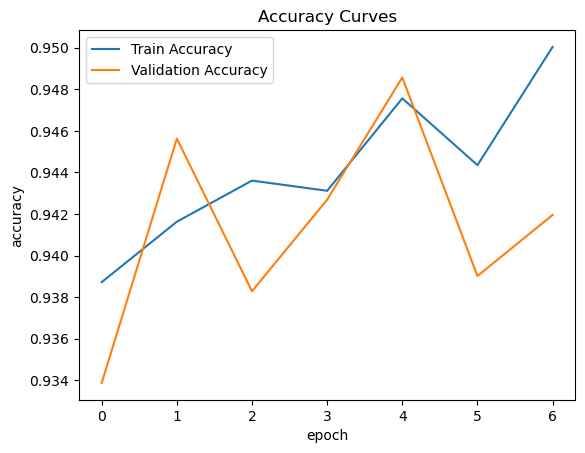

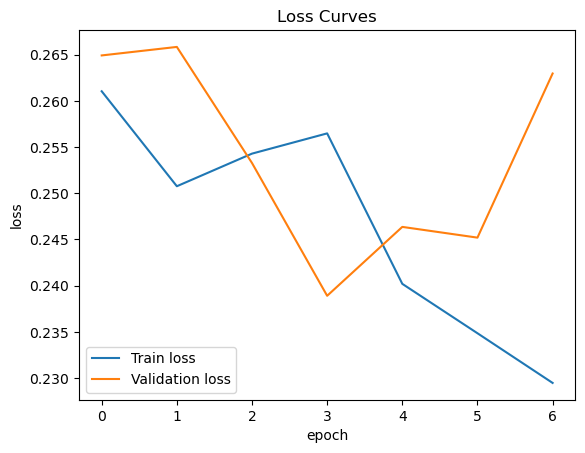

In [20]:
loss_curve_plot(model_history)

In [21]:
model=tf.keras.models.load_model("/kaggle/working/model.hdf5")
y_true=test_datagen.classes
    
y_pred=model.predict(test_datagen)
y_pred=tf.math.round(y_pred).numpy()
y_pred=y_pred.argmax(axis=1)

supervised_metrics(y_true, y_pred)

22/22 [==============================] - 108s 5s/step
Accuracy : 94.34239529757531 %
F1 Score : 0.9443642849491533
Recall : 0.9434239529757531
Precision : 0.9469551812505016


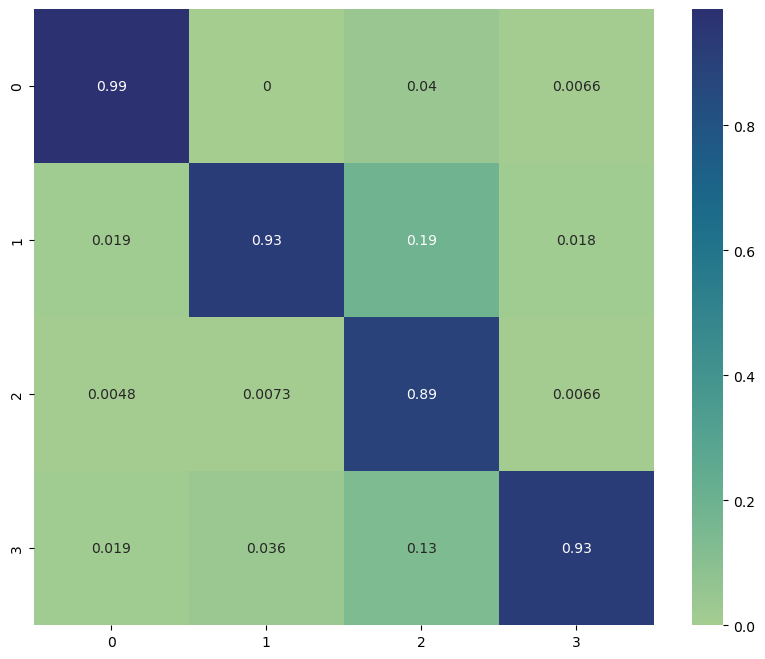

In [22]:
confusion_matrix_plot(y_true, y_pred, figsize=(10,8))

In [18]:
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
model_base = hub.KerasLayer(model_url, input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable=True )
model_base.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0831521>]